In [10]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout
from keras.layers import Convolution2D
from keras.layers.convolutional import Cropping2D
from keras import regularizers

In [2]:
def get_data(path):
    """
    Get data from a directory. Each directory has a 'driving_log.csv' file, and
    an 'IMG' folder.
    Input: path should have the slash in the end, e.g './data/'
    """
    lines = []
    with open(path + 'driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)
    # read the csv file 
    images = []
    measurements = []
    for line in lines:
        source_path = line[0]
        filename = source_path.split('/')[-1]
        current_path = path + 'IMG/' + filename
        image = cv2.imread(current_path)
        # convert image from BGR to YUV planes
        image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        images.append(image)
        measurement = float(line[3])
        measurements.append(measurement)
    # convert to numpy array
    X = np.array(images)
    y = np.array(measurements)
    return X, y

In [3]:
X_train1, y_train1 = get_data('./data-1/')
X_train2, y_train2 = get_data('./data-2/')
X_train3, y_train3 = get_data('./data-3/')

In [5]:
X_train = np.concatenate((X_train1, X_train2, X_train3))
y_train = np.concatenate((y_train1, y_train2, y_train3))

In [6]:
print(X_train.shape)
print(y_train.shape)

(8039, 160, 320, 3)
(8039,)


In [13]:
# create a simple model
input_shape = (160, 320, 3)
model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=input_shape))
model.add(Cropping2D(cropping=((70,25),(0,0))))
model.add(Convolution2D(24,5,5, subsample=(2,2), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(36,5,5, subsample=(2,2), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(48,5,5, subsample=(2,2), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(64,3,3, activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(64,3,3, activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, 
                W_regularizer=regularizers.l2(10e-4),
                b_regularizer=regularizers.l2(10e-4),
                activity_regularizer=None))
model.add(Dropout(0.5))
model.add(Dense(50,
                W_regularizer=regularizers.l2(10e-4),
                b_regularizer=regularizers.l2(10e-4),
                activity_regularizer=None))
model.add(Dropout(0.5))
model.add(Dense(10,
                W_regularizer=regularizers.l2(10e-4),
                b_regularizer=regularizers.l2(10e-4),
                activity_regularizer=None))
model.add(Dropout(0.5))
model.add(Dense(1))

In [15]:
model.compile(loss='mse', optimizer='adam')
history_object = model.fit(X_train, y_train, validation_split=0.2,
          shuffle=True, nb_epoch=40)

Train on 6431 samples, validate on 1608 samples
Epoch 1/40
6431/6431 [==============================] - 9s - loss: 0.0157 - val_loss: 0.0656
Epoch 2/40
6431/6431 [==============================] - 9s - loss: 0.0156 - val_loss: 0.0656
Epoch 3/40
6431/6431 [==============================] - 8s - loss: 0.0156 - val_loss: 0.0655
Epoch 4/40
6431/6431 [==============================] - 9s - loss: 0.0156 - val_loss: 0.0658
Epoch 5/40
6431/6431 [==============================] - 9s - loss: 0.0156 - val_loss: 0.0658
Epoch 6/40
6431/6431 [==============================] - 9s - loss: 0.0156 - val_loss: 0.0655
Epoch 7/40
6431/6431 [==============================] - 9s - loss: 0.0156 - val_loss: 0.0655
Epoch 8/40
6431/6431 [==============================] - 9s - loss: 0.0156 - val_loss: 0.0656
Epoch 9/40
6431/6431 [==============================] - 9s - loss: 0.0156 - val_loss: 0.0656
Epoch 10/40
6431/6431 [==============================] - 9s - loss: 0.0156 - val_loss: 0.0656
Epoch 11/40
6431/6431

In [16]:
model.save('model.h5')

dict_keys(['val_loss', 'loss'])


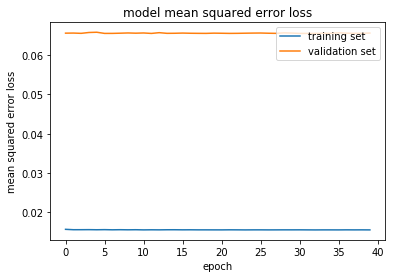

In [17]:
# print the output of model
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()